# Convolutional Autoencoder

In [148]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model, layers, utils
from tensorflow.keras.datasets import fashion_mnist

In [149]:
def build_autoencoder(input_shape=(28,28,1), encoding_size=32, alpha=0.2):
    inputs = layers.Input(shape=input_shape)
    encoder = layers.Conv2D(32, 3, 2, "same")(inputs)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.LeakyReLU(alpha)(encoder)

    encoder = layers.Conv2D(64, 3, 2, "same")(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.LeakyReLU(alpha)(encoder)

    encoder_output_shape = encoder.shape
    encoder = layers.Flatten()(encoder)
    encoder_output = layers.Dense(encoding_size)(encoder)
    encoder_model = Model(inputs, encoder_output)


    decoder_input = layers.Input(shape=(encoding_size,))
    target_shape = tuple(encoder_output_shape[1:])

    decoder = layers.Dense(np.prod(target_shape))(decoder_input)
    decoder = layers.Reshape(target_shape)(decoder)
    decoder = layers.Conv2DTranspose(64,3,2,"same")(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.LeakyReLU(alpha)(decoder)

    decoder = layers.Conv2DTranspose(32,3,2,"same")(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.LeakyReLU(alpha)(decoder)

    decoder_output = layers.Conv2DTranspose(1, 3, padding="same", 
                                     activation="sigmoid")(decoder)

    decoder_model = Model(decoder_input, decoder_output)

    encoder_model_output = encoder_model(inputs)
    decoder_model_output = decoder_model(encoder_model_output)
    autoencoder_model = Model(inputs, decoder_model_output)
    return encoder_model, decoder_model, autoencoder_model

## Plot original vs generated images

In [150]:
def plot_original_vs_generated(original, generated):
    num_images = 15
    sample = np.random.randint(0, len(original), num_images)
    def stack(data):
        images = data[sample]
        return np.vstack([np.hstack(images[:5]),
                          np.hstack(images[5:10]),
                          np.hstack(images[10:15])])
    def add_text(image, text, position):
        pt1 = position
        pt2 = (pt1[0] + 10 + (len(text) * 22), pt1[1] - 45)
        cv2.rectangle(image, pt1, pt2, (255, 255, 255), -1)
        cv2.putText(image, text, position, fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                    fontScale=1.3, color=(0,0,0), thickness=4)
    original = stack(original)
    generated = stack(generated)
    mosaic = np.vstack([original, generated])
    mosaic = cv2.resize(mosaic, (860, 860), interpolation=cv2.INTER_AREA)
    mosaic = cv2.cvtColor(mosaic, cv2.COLOR_GRAY2BGR)

    add_text(mosaic, 'Original', (50, 100))
    add_text(mosaic, 'Generated', (50, 520))

    plt.axis("off")
    plt.title('Mosaic')
    plt.imshow(mosaic)

## Get Dataset

In [151]:
(X_train, _), (X_test, _) = fashion_mnist.load_data()
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [152]:
train_noise = np.random.normal(loc=0.5, scale=0.45, size=X_train.shape)
test_noise = np.random.normal(loc=0.5, scale=0.45, size=X_test.shape)

In [153]:
X_train_noisy =np.clip(X_train + train_noise, 0, 1)
X_test_noisy = np.clip(X_test + test_noise, 0, 1)


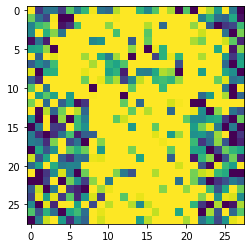

In [154]:
plt.imshow(X_train_noisy[1].squeeze())

In [155]:
# train_data = tf.data.Dataset.from_tensor_slices((X_train_noisy.squeeze().astype("float32"), X_train))
# test_data = tf.data.Dataset.from_tensor_slices((X_test_noisy.astype("float32"), X_test))

#train_data.shuffle(buffer_size=512, seed=42).prefetch(tf.data.AUTOTUNE)
#test_data.shuffle(buffer_size=512, seed=42).prefetch(tf.data.AUTOTUNE)

## Build, compile and train the model

In [156]:
encoder, decoder, autoencoder = build_autoencoder(encoding_size=256)
autoencoder.compile(optimizer = 'adam', loss='mse')

In [157]:
callbacks = []
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
callbacks.append(tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr if epoch <10 else lr * tf.math.exp(-0.1)))
callbacks.append(tf.keras.callbacks.ModelCheckpoint("autoencoder(denoising) V1.h5", save_best_only=True))

In [158]:
train_data

<TensorSliceDataset shapes: ((28, 28), (28, 28, 1)), types: (tf.float32, tf.float32)>

In [159]:
X_train_noisy.shape

(60000, 28, 28, 1)

In [160]:
EPOCHS = 300
BATCH_SIZE = 128
history = autoencoder.fit(X_train_noisy, X_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                shuffle=True, validation_data=(X_test_noisy, X_test))

Epoch 1/300
469/469 [==============================] - 20s 36ms/step - loss: 0.0221 - val_loss: 0.0174
Epoch 2/300
469/469 [==============================] - 12s 26ms/step - loss: 0.0143 - val_loss: 0.0157
Epoch 3/300
469/469 [==============================] - 10s 22ms/step - loss: 0.0131 - val_loss: 0.0139
Epoch 4/300
469/469 [==============================] - 10s 22ms/step - loss: 0.0125 - val_loss: 0.0126
Epoch 5/300
469/469 [==============================] - 10s 22ms/step - loss: 0.0121 - val_loss: 0.0126
Epoch 6/300
469/469 [==============================] - 10s 22ms/step - loss: 0.0117 - val_loss: 0.0123
Epoch 7/300
469/469 [==============================] - 10s 22ms/step - loss: 0.0114 - val_loss: 0.0129
Epoch 8/300
469/469 [==============================] - 10s 21ms/step - loss: 0.0111 - val_loss: 0.0153
Epoch 9/300
469/469 [==============================] - 11s 23ms/step - loss: 0.0109 - val_loss: 0.0122
Epoch 10/300
469/469 [==============================] - 10s 21ms/step - l

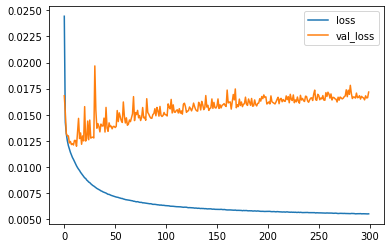

In [144]:
pd.DataFrame(history.history).plot()

In [145]:
samples = 10
indexes = np.random.choice(len(X_test_noisy), samples)
test_vals = X_test_noisy[indexes]
predictions = autoencoder.predict(test_vals)

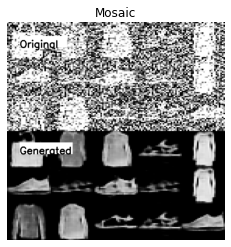

In [147]:
original_shape = (samples, 28, 28)
predictions = predictions.reshape(original_shape)
test_vals = test_vals.reshape(original_shape)
predictions = (predictions * 255).astype("uint8")
test_vals = (test_vals * 255).astype("uint8")

plot_original_vs_generated(test_vals, predictions)